**Understanding Oxygen Dynamics in Oceanographic data : The Influence of Environmental Variables**

**By:
Varun Mallela**

This research investigates the complex relationships between various oceanographic variables and oxygen concentration within the California Current Ecosystem. Using a subset of the California Cooperative Oceanic Fisheries Investigations (CalCOFI) dataset spanning 2017-2021, I have employed statistical regression techniques to understand how factors such as depth, temperature, salinity, and nutrients influence oxygen dynamics in this region. This analysis builds upon the rich historical CalCOFI dataset collected from 1949-2021. A sample from 2017-2021 was used due to the large size of data in the original dataset which contains records from 1949.

Overall Research on:

- To investigate relationships between oxygen concentration in oceanographic data and physical and nutrient features through regression modelling.

### Main problems to be answered in this research:

1) Clean the dataset
2) Check for multi collinearity between independent variables.
3) Investigate relationships between oxygen concentraion and physical and nutrient features by performing multiple linear regression
4) Check if depth is a significant predictor for response variable - oxygen concentration using t-test and values from regression summary
5) Perform a statistical hypothesis test to see if there a significant relationship between any of the predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop, NO2uM, and NH3uM) and the dissolved oxygen levels (O2ml_L) in seawater - Use ANOVA
6) Perform Diagnostics for the regression model - Residuals, goodness of fit, feature selection.
7) Use model selection with various performance metrics like AIC, BIC, MSPE, R^2 and adj R^2 and select best model.



### **Data Cleaning**

Before starting the cleaning process, I want to filter out the rows in my main dataset to only include in the year range 2017-2021. To do this, I'm using another dataset from same source, which has a common key 'Cst_Cnt' with my main dataset and also it has year column. So, the idea is to merge the datasets and filter.

In [268]:
# Importing Libraries for cleaning
library(dplyr)   # For data manipulation
library(readr)   # For reading CSV files


In [269]:
 options(warn = -1) # ignoring warnings

In [270]:
bottle_df <- read_csv("Bottle.csv",show_col_types = FALSE) # reading the main dataset

In [271]:
cast_df <- read_csv("Cast.csv",show_col_types = FALSE) # importing another dataset which contains year values

In [272]:
filtered_cast <- cast_df %>%
  filter(Year >= 2017 & Year <= 2021) %>%
  select(Cst_Cnt, Year)  # Keep only these columns


Here in the above code, we are filtering columns with year values between 2017-2021.

In [273]:
merged_df <- merge(bottle_df, filtered_cast, by = "Cst_Cnt") # merging the two datasets.


In [274]:
count(merged_df)

n
<int>
30508


We can see that we have a total of 30508 values to work with our analysis.

In [275]:
str(merged_df)

'data.frame':	30508 obs. of  63 variables:
 $ Cst_Cnt            : num  34405 34405 34405 34405 34405 ...
 $ Btl_Cnt            : num  864864 864865 864866 864867 864868 ...
 $ Sta_ID             : chr  "063.3 052.0" "063.3 052.0" "063.3 052.0" "063.3 052.0" ...
 $ Depth_ID           : chr  "20-1701RL-MX-027-1949-06330520-0000A-7" "20-1701RL-MX-027-1949-06330520-0010A-7" "20-1701RL-MX-027-1949-06330520-0020A-7" "20-1701RL-MX-027-1949-06330520-0030A-7" ...
 $ Depthm             : num  0 10 20 30 50 75 0 10 20 30 ...
 $ T_degC             : num  12.3 12.3 12.2 12.3 12.2 ...
 $ Salnty             : num  33.2 33.2 33.2 33.2 33.3 ...
 $ O2ml_L             : num  5.92 5.92 5.88 5.8 5.34 ...
 $ STheta             : num  25.1 25.1 25.1 25.1 25.2 ...
 $ O2Sat              : num  97.3 97.2 96.6 95.3 87.7 ...
 $ Oxy_µmol/Kg        : num  258 258 256 253 233 ...
 $ BtlNum             : num  NA NA NA NA NA NA NA NA NA NA ...
 $ RecInd             : num  7 7 7 7 7 7 7 7 7 7 ...
 $ T_prec            

From the above code, we can see all the variables present in my dataset, my main foucus is to take 'O2ml_L' which is milliliters of dissolved oxygen per liter seawater as my dependent variable and do my regression analysis. Many variables in my dataset are unnecessary for my analysis, most of the variables are either quality codes or index variables. So, I plan to first remove the variables no needed for my analysis.

In [276]:
keep_cols <- c("Depthm", "T_degC", "Salnty", "PO4uM", "SiO3uM", "NO3uM", "O2ml_L",'Phaeop', 'NO2uM', 'NH3uM')

# Drop unnecessary columns
merged_df <- merged_df %>% select(all_of(keep_cols))

I have choosen the following variables for my analysis: 

**Core Physical Factors**:

Depthm (Depth in meters)
T_degC (Temperature of water)
Salnty (Salinity of water
)

**Nutrients**:

PO4µM Phosphate concentratione)
SiO3µM (Silicat concentratione)
NO3µM (Nitrat concentratione)
Phaeo (Phaeophytin concentration measured fluorometrically)p
NO2u (Nitrite concentration
)M
NH3 (Ammonium concentration
)uM


In [277]:
print(colnames(merged_df))  # This will output a character vector of column names


 [1] "Depthm" "T_degC" "Salnty" "PO4uM"  "SiO3uM" "NO3uM"  "O2ml_L" "Phaeop"
 [9] "NO2uM"  "NH3uM" 


Now, first I will be checking for missing values

In [278]:
missing_counts <- colSums(is.na(merged_df))
print(missing_counts)

Depthm T_degC Salnty  PO4uM SiO3uM  NO3uM O2ml_L Phaeop  NO2uM  NH3uM 
     0      6      2   2916   2914   2913   1079  10114   3642   4981 


We can see from the above output that, variables temperature and salinity have vary less missing values, so I plan to remove rows of missing values of these variables.

For other nutrient variables, there are quite a number of missing values, I plan to check for skewness and decide which type of imputation method (mean/mode) to use to fix those missing values.

In [279]:
summary(merged_df)

     Depthm          T_degC           Salnty           PO4uM      
 Min.   :  0.0   Min.   : 4.757   Min.   : 9.501   Min.   :0.000  
 1st Qu.: 30.0   1st Qu.: 8.292   1st Qu.:33.453   1st Qu.:0.330  
 Median :100.0   Median :10.572   Median :33.672   Median :1.485  
 Mean   :154.5   Mean   :11.361   Mean   :33.501   Mean   :1.459  
 3rd Qu.:250.0   3rd Qu.:14.325   3rd Qu.:34.056   3rd Qu.:2.380  
 Max.   :751.0   Max.   :99.000   Max.   :34.403   Max.   :4.110  
                 NA's   :6        NA's   :2        NA's   :2916   
     SiO3uM           NO3uM           O2ml_L             Phaeop      
 Min.   :  0.00   Min.   : 0.00   Min.   :-200.222   Min.   :-1.899  
 1st Qu.:  2.44   1st Qu.: 0.57   1st Qu.:   1.761   1st Qu.: 0.049  
 Median : 17.83   Median :18.59   Median :   3.669   Median : 0.108  
 Mean   : 24.88   Mean   :17.37   Mean   :   3.577   Mean   : 0.186  
 3rd Qu.: 41.70   3rd Qu.:30.50   3rd Qu.:   5.617   3rd Qu.: 0.232  
 Max.   :113.24   Max.   :43.08   Max.   :  

Before proceeding I have printed the summary statistics of all variables, later I will make to compare this statistics after cleaning to ensure there was no major change.

In [280]:
library(dplyr)

merged_df <- merged_df %>%
  filter(!is.na(T_degC) & !is.na(Salnty))


I have removed null values from temperature and salinity variables.

In [281]:
library(dplyr)

merged_df <- merged_df %>%
   filter(O2ml_L > 0) %>%
   filter(Phaeop > 0)


I have removed negative values from oxygen concentration and Phaeophytin concentration columns

**Checking For Skewness For nutrient variables uisng density plots**

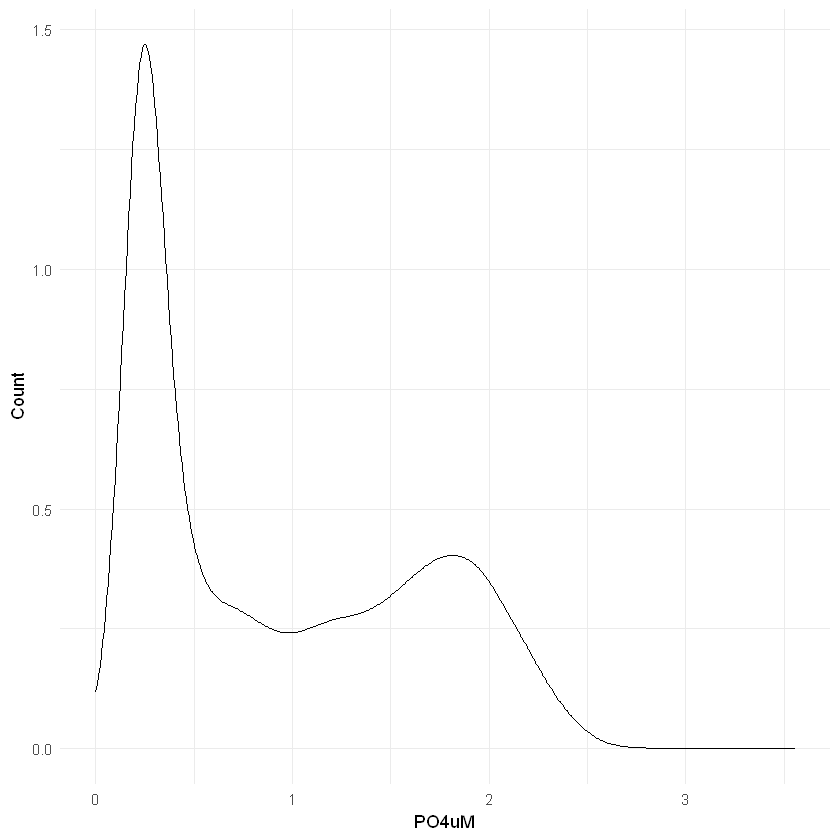

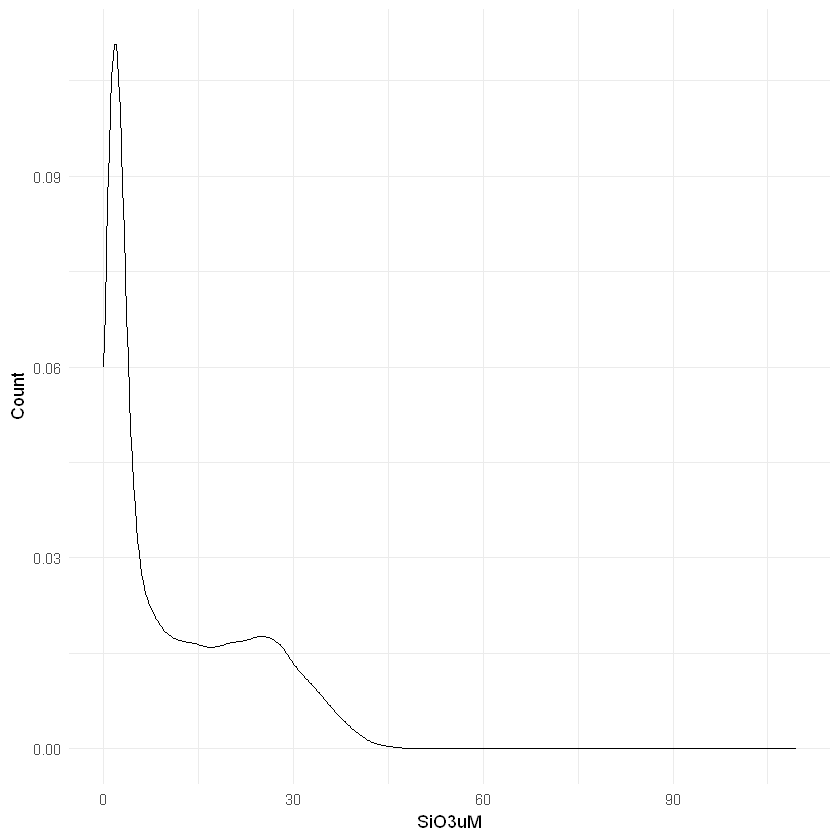

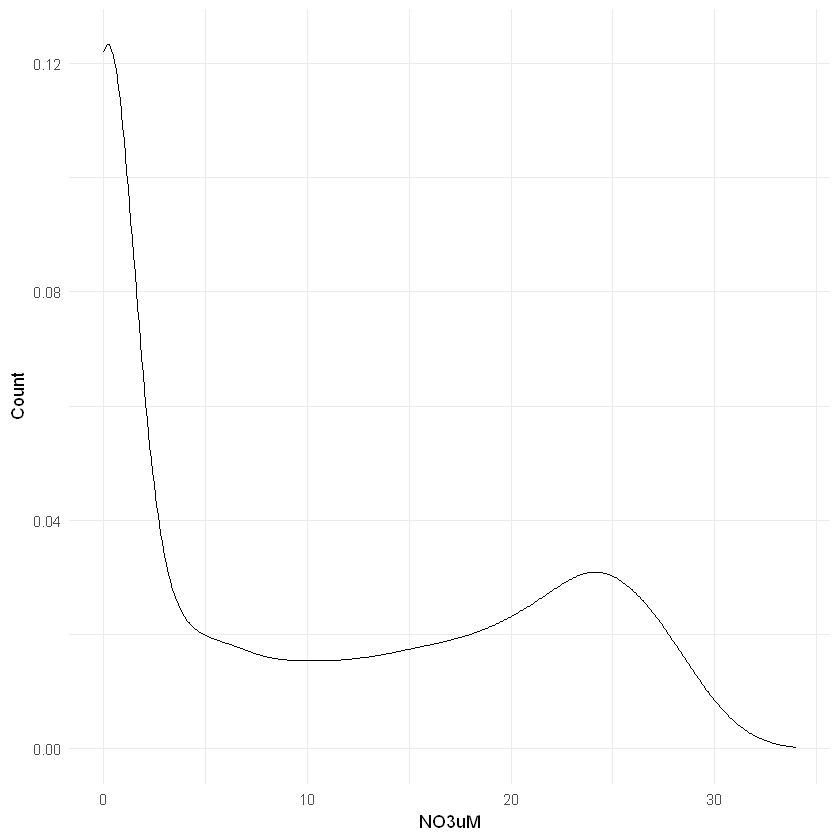

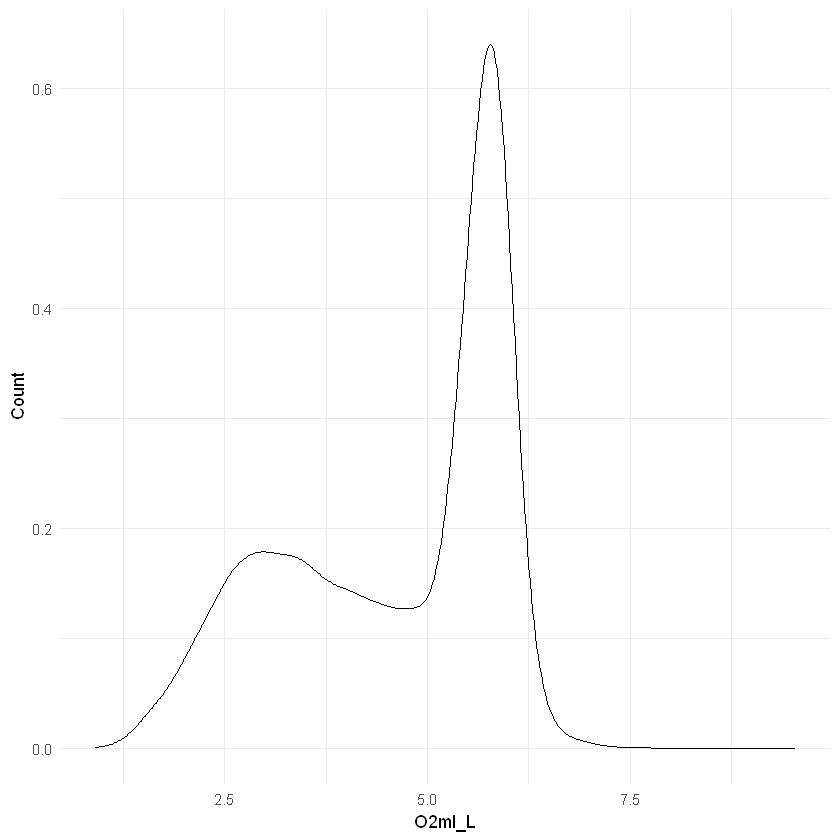

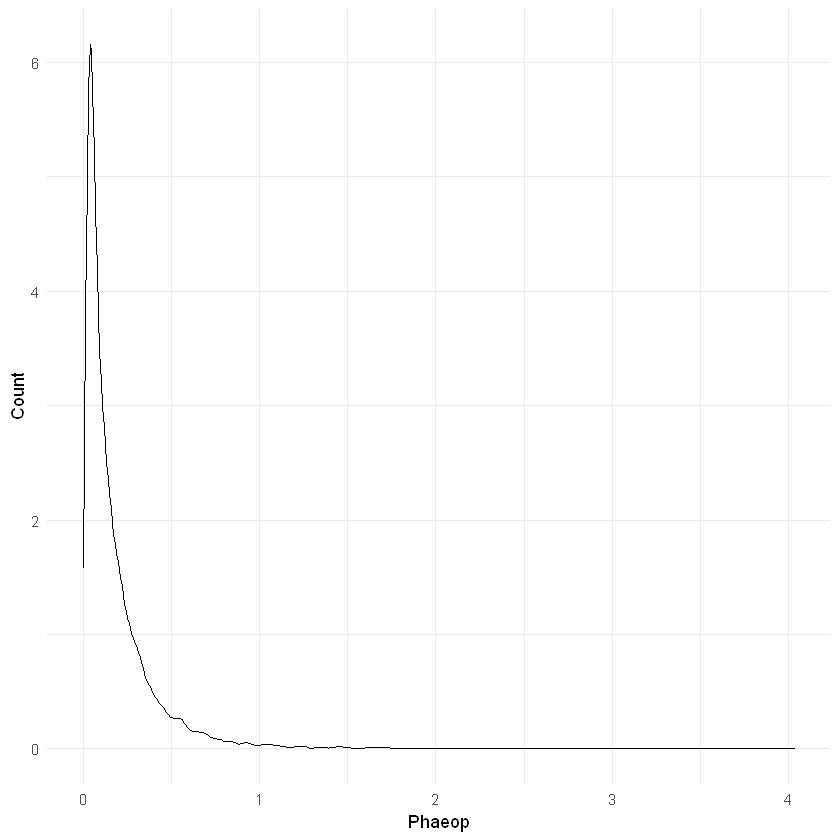

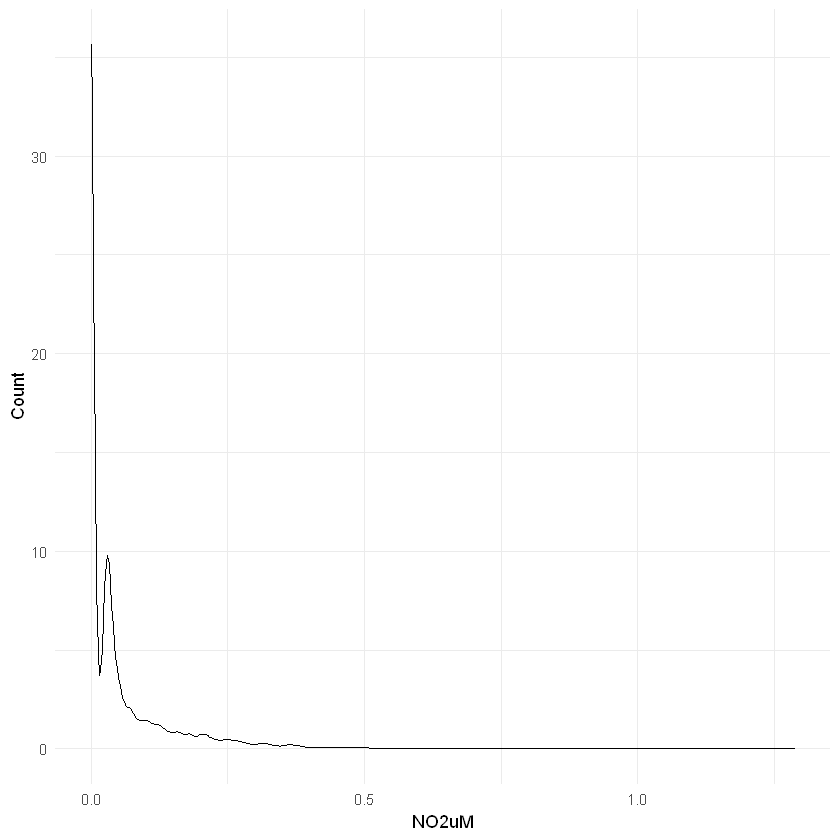

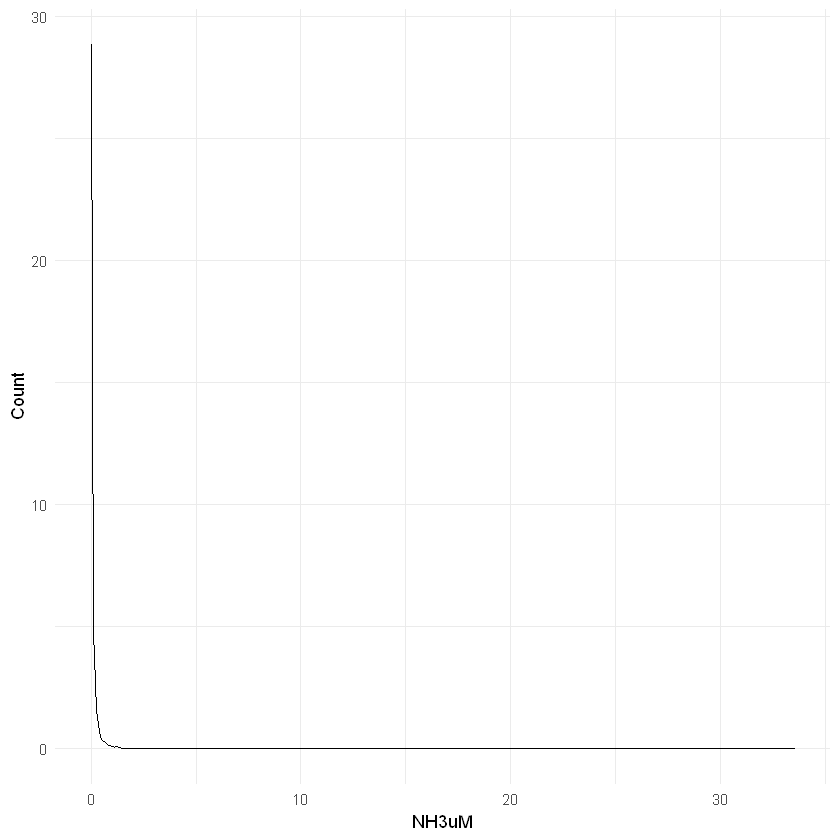

In [282]:
library(ggplot2)

# List of variables to plot
variables <- c("PO4uM" ,"SiO3uM" ,"NO3uM",  "O2ml_L", "Phaeop", 'NO2uM',  'NH3uM')

# Creating individual plots for each variable
for (var in variables) {
  plot <- ggplot(merged_df, aes(x = .data[[var]])) +
    geom_density()+
    labs(x = var, y = "Count") +
    theme_minimal()

  print(plot)
}



From the above plots we can see that all these variables are skewed and dont follow a normal distribution, so I will be using median for my imputation methods

In [283]:
# install.packages("tidyverse")

# Load the dplyr package
library(dplyr)

# Replace missing values with the median for the specified columns
merged_df <- merged_df %>%
  mutate(
    PO4uM = ifelse(is.na(PO4uM), median(PO4uM, na.rm = TRUE), PO4uM),
    SiO3uM = ifelse(is.na(SiO3uM), median(SiO3uM, na.rm = TRUE), SiO3uM),
    NO3uM = ifelse(is.na(NO3uM), median(NO3uM, na.rm = TRUE), NO3uM),
    O2ml_L = ifelse(is.na(O2ml_L), median(O2ml_L, na.rm = TRUE), O2ml_L),
    Phaeop = ifelse(is.na(Phaeop), median(Phaeop, na.rm = TRUE), Phaeop),
    NO2uM  = ifelse(is.na(NO2uM), median(NO2uM, na.rm = TRUE), NO2uM),
    NH3uM  = ifelse(is.na(NH3uM), median(NH3uM, na.rm = TRUE), NH3uM)
  )

# Checking the summary to confirm changes
summary(merged_df)


     Depthm           T_degC           Salnty          PO4uM      
 Min.   :  0.00   Min.   : 7.636   Min.   :24.19   Min.   :0.000  
 1st Qu.: 20.00   1st Qu.:10.071   1st Qu.:33.39   1st Qu.:0.270  
 Median : 61.00   Median :12.612   Median :33.55   Median :0.680  
 Mean   : 72.85   Mean   :12.883   Mean   :33.32   Mean   :0.912  
 3rd Qu.:121.00   3rd Qu.:15.163   3rd Qu.:33.74   3rd Qu.:1.550  
 Max.   :204.00   Max.   :23.145   Max.   :34.32   Max.   :3.560  
     SiO3uM           NO3uM            O2ml_L          Phaeop      
 Min.   :  0.00   Min.   : 0.000   Min.   :0.915   Min.   :0.0010  
 1st Qu.:  1.82   1st Qu.: 0.050   1st Qu.:3.424   1st Qu.:0.0490  
 Median :  5.95   Median : 5.980   Median :5.209   Median :0.1080  
 Mean   : 10.97   Mean   : 9.778   Mean   :4.616   Mean   :0.1867  
 3rd Qu.: 19.22   3rd Qu.:19.648   3rd Qu.:5.763   3rd Qu.:0.2320  
 Max.   :109.47   Max.   :34.000   Max.   :9.539   Max.   :4.0370  
     NO2uM             NH3uM         
 Min.   :0.00000 

Due to the presence of skewness I have replaced null values in these nutrient columns with median. I have printed summary statistics to check if there was any significant changes after imputation. From the summary I can say that there was not a significant change after imputation.

From the summary statistics, we can see that for some columns there are some maximum values which are unrealistic, so I decided to remove them.

In [284]:
# Removing very large values, possible error values due to very high unrealistic values
merged_df <- subset(merged_df, SiO3uM != 109.47 )
merged_df <- subset(merged_df,  NH3uM  != 33.58000 )
merged_df <- subset(merged_df,  NO3uM  != 34.000 )
merged_df <- subset(merged_df,  Depthm  != 204.00 )

In [285]:
head(merged_df)

,Depthm,T_degC,Salnty,PO4uM,SiO3uM,NO3uM,O2ml_L,Phaeop,NO2uM,NH3uM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,13.013,33.3230,0.73,7.43,5.80,5.615,0.486,0.245,0.08
2,1,13.013,33.3230,0.73,7.43,5.80,5.615,0.486,0.245,0.08
3,6,13.010,33.3200,0.73,7.36,5.73,5.633,0.366,0.244,0.14
4,10,13.001,33.3268,0.73,7.45,5.87,5.620,0.425,0.246,0.15
5,20,12.913,33.3374,0.74,7.69,6.19,5.504,0.409,0.253,0.20
6,30,12.883,33.3468,0.77,7.82,6.40,5.439,0.424,0.260,0.22


The cleaning process is completed and, we can the see the head of the final dataset which will be now used for regression analysis.

### **Regression Modelling**

Assumption of Regression Model:

1) Linearity - There must be a linear relationship between the response variable and the independent variables. 

2) Multivariate Normality - We assume that residuals are normally distributed.

3) No Multicollinearity - We assume that the independent variable are not highly correlated with each other.

4) Homoscedasticity - We assume that the variance of error terms is similar across the values of the independent variables.

In [286]:
set.seed(145764)
n = floor(0.8 * nrow(merged_df)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(merged_df)), size = n) #randomly sample indicies to be included in the training set

train = merged_df[index, ] #set the training set to be the randomly sampled rows of the dataframe
test = merged_df[-index, ] #set the testing set to be the remaining rows
cat("There are", dim(train)[1], "rows and",dim(train)[2],"columns in the training set. ")  #checking the dimensions
cat("There are", dim(test)[1], "rows and",dim(test)[2],"columns in the testing set.")  #checking the dimensions

There are 16238 rows and 10 columns in the training set. There are 4060 rows and 10 columns in the testing set.

To start of the regression modelling, I have first randomly split my dataset into train and split set, with 80% of the data for training and 20% of data for testing.

In my analysis, I will first of check for presence of multicollinearity and remove it to ensure proper results i.e to ensure statistical significance of independent variables

Correlation Plot

In [287]:
install.packages("corrplot")

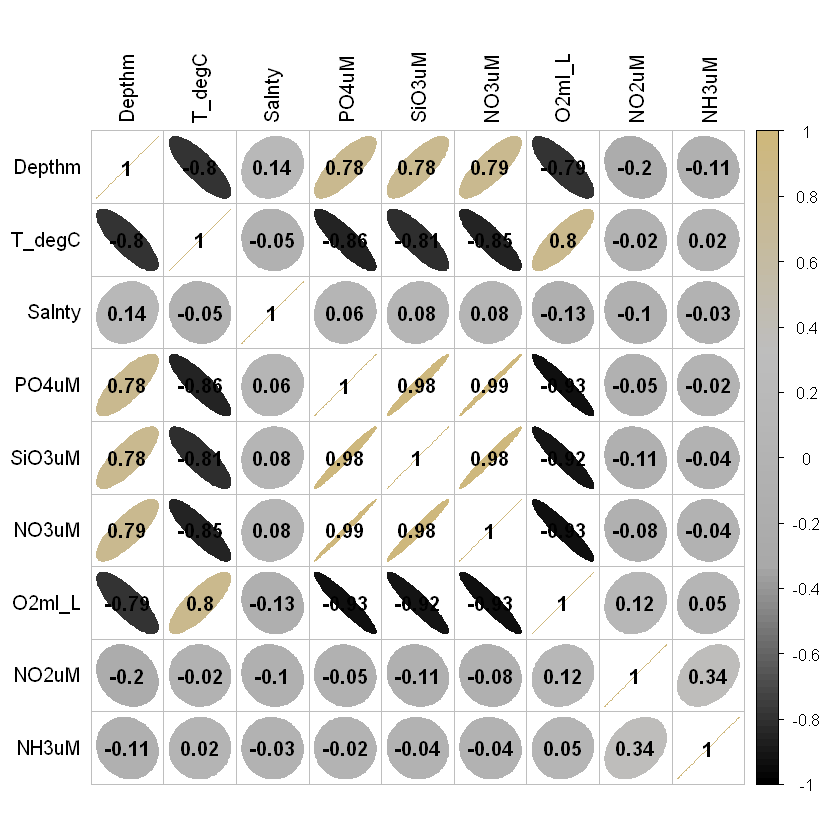

In [288]:
library('corrplot')
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(merged_df[,-8]), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

I have then plotted a correlation, plot to understand which independent variables are correleted among each other. From the plot I can see that the variables 'PO4uM', 'NO3uM', and 'SiO3uM' exihibt high correlation between other variables. This arries a problem of multicollinearity. To verify this futher and to decide whether to keep these variables I will be using VIF values. 

In [289]:
model <- lm(O2ml_L ~ Depthm +T_degC	+ Salnty +PO4uM+SiO3uM+	NO3uM+Phaeop+NO2uM+NH3uM, data = train)

I have use lm function to model a multiple linear regression model with oxygen concentration beign my dependent variable.

In [290]:
library(car)


calculate_vifs <- function(model) {
  vif(model)
}

vifs <- calculate_vifs(model)
cond_number <- kappa(model)


print("VIFs:")
print(vifs)

[1] "VIFs:"
    Depthm     T_degC     Salnty      PO4uM     SiO3uM      NO3uM     Phaeop 
  4.379273   6.482290   1.046232 136.878649  31.502541 104.245633   1.482422 
     NO2uM      NH3uM 
  1.543590   1.240594 


From the above VIF values we can see the all the mentioned above variables - 'PO4uM', 'NO3uM', and 'SiO3uM'  have very high values than normal threshold. So I plan to remove 2 of these values and check again, so I will be removing -  'PO4uM', 'NO3uM' since these variables have VIF values more than 100.

In [291]:
model <- lm(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop	+ NO2uM	+ NH3uM , data = train)

In [293]:
vifs <- calculate_vifs(model)
cond_number <- kappa(model)


print("VIFs:")
print(vifs)

[1] "VIFs:"
  Depthm   T_degC   Salnty   SiO3uM   Phaeop    NO2uM    NH3uM 
4.079090 4.167353 1.034154 3.312954 1.426863 1.490178 1.226217 


After removing the two variables, we can see from the above output that all the VIF values are below 5, so we can say that there no collinearity present here according to the above results.

Now let's, focus on this new model let's see its summary.

In [294]:
summary(model)


Call:
lm(formula = O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + 
    NO2uM + NH3uM, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7665 -0.2659  0.0344  0.3043  8.0885 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  6.4449114  0.1014648   63.519   <2e-16 ***
Depthm      -0.0023178  0.0001356  -17.098   <2e-16 ***
T_degC       0.0649608  0.0026139   24.852   <2e-16 ***
Salnty      -0.0483205  0.0028386  -17.023   <2e-16 ***
SiO3uM      -0.0865234  0.0006587 -131.361   <2e-16 ***
Phaeop       0.3314825  0.0198599   16.691   <2e-16 ***
NO2uM       -0.0897524  0.0526548   -1.705   0.0883 .  
NH3uM        0.0141123  0.0142852    0.988   0.3232    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5051 on 16230 degrees of freedom
Multiple R-squared:  0.8603,	Adjusted R-squared:  0.8602 
F-statistic: 1.428e+04 on 7 and 16230 DF,  p-value: < 2.2e-16


The above summary suggest that 86% of variance dissolved in oxygen levels is explained by the model. We can see that all the predictors except 'NO2uM' and 'NH3uM' are statistically very good predictors with the response variable - O2ml_L i.e. oxygen concentration.

### **Hypothesis Test - t test**

Let's verify this by using t -test with to check if Depthm is a significant predictor for the response variable - O2ml_L.



### Step 1: Formulate Hypotheses
- **Null Hypothesis (H₀)**: The coefficient for `Depthm` is equal to zero ($\beta_{Depthm} = 0$),
    this implyes that there is no significant relationship between `Depthm` and `O2ml_L`.
  
- **Alternative Hypothesis (H₁)**: The coefficient for `Depthm` is not equal to zero ($\beta_{Depthm} \neq 0$), this implies that there is a significant relationship between `Depthm` and `O2ml_L`.

Significance level : 0.05

### Step 2: Calculating the Test Statistic
The t-statistic can be calculated using the formula:
$$
t = \frac{\hat{\beta}_{Depthm}}{SE_{\beta_{Depthm}}}
$$

From the regression summary we have:
- $\hat{\beta}_{Depthm} = -0.0023178$
- $SE_{\beta_{Depthm}} = 0.0001356$

$$
t = \frac{-0.0023178}{0.0001356} \approx -17.098
$$

### Step 3: Determining the Degrees of Freedom
The degrees of freedom (df) for the test can calculated as $$ n - p - 1 $$, where:
- $$n = 16238$$ (total number of observations)
- $$p = 7$$ (number of predictors)

$
df = 16230
$

### Step 4: Determining the Critical Value and p-value
With $$df = 16230$$, the p-value for `Depthm`is given in summary of regression model:

- **p-value**: $<2e-16$, which is extremely small.

### Step 5: Conclusion
Based on the p-value, which is much smaller significance level 0.05 we reject the null hypothesis. This indicates that there is a statistically significant relationship between `Depthm` and `O2ml_L`. 

The negative coefficient of ($-0.0023178$) suggests that as `Depthm` increases, the dissolved oxygen level (`O2ml_L`) decreases.

Now lets perform a statistical hypothesis test to see if there a significant relationship between any of the predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop, NO2uM, and NH3uM) and the dissolved oxygen levels (O2ml_L) in seawater. I will be using ANOVA for this.

### ANOVA

Assumptions of the ANOVA test: 
- The observations are independent and randomly obtained from the population defined by the factor levels.
- The data in each group (factor level) is normally distributed.
- The data in each group has the same variance.

In [295]:
# Fitting the linear model
model <- lm(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + NO2uM + NH3uM, data = train)

# Performing an ANOVA test
anova_results <- anova(model)

# View the ANOVA table
print(anova_results)

Analysis of Variance Table

Response: O2ml_L
             Df  Sum Sq Mean Sq    F value Pr(>F)    
Depthm        1 18558.5 18558.5 72732.6462 <2e-16 ***
T_degC        1  2321.8  2321.8  9099.2837 <2e-16 ***
Salnty        1    67.5    67.5   264.3939 <2e-16 ***
SiO3uM        1  4475.8  4475.8 17541.1307 <2e-16 ***
Phaeop        1    76.2    76.2   298.5607 <2e-16 ***
NO2uM         1     0.5     0.5     2.0971 0.1476    
NH3uM         1     0.2     0.2     0.9760 0.3232    
Residuals 16230  4141.3     0.3                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


From the above ANOVA result we can formulate and conclude the following:

significane level is 0.01
### Hypotheses
- **Null Hypothesis (H₀)**: None of the predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop, NO2uM, and NH3uM) have a statistically significant relationship with the response variable, O2ml_L (all coefficients are zero).
  
- **Alternative Hypothesis (H₁)**: At least one predictor has a statistically significant relationship with the response variable, O2ml_L. (Atleast one coefficient is different from zero)
  

### Results from ANOVA Table

- **Depthm**: F(1, 16230) = 72732.65, p < 2e-16. Here the pvalue is very small, so this indicates a significant relationship.
- **T_degC**: F(1, 16230) = 9099.28, p < 2e-16. Here the pvalue is very small, so this indicates a significant relationship.
- **Salnty**: F(1, 16230) = 264.39, p < 2e-16. Here the pvalue is very small, so this indicates a significant relationship.
- **SiO3uM**: F(1, 16230) = 17541.13, p < 2e-16. Here the pvalue is very small, so this indicates a significant relationship.
- **Phaeop**: F(1, 16230) = 298.56, p < 2e-16. Here the pvalue is very small, so this indicates a significant relationship.
- **NO2uM**: F(1, 16230) = 2.10, p = 0.1476. Here the pvalue is greater  than 0.01 significance so, this suggests no significant relationship.
- **NH3uM**: F(1, 16230) = 0.98, p = 0.3232. Here the pvalue is greater  than 0.01 significance so, this suggests no significant relationship.

### Conclusion
Based on the ANOVA table we can conclude the following:
- Since we have more than one variable which has significant relation with the response variable , there is significant evidence to reject the null hypothesis at the α = 0.01 level. So, this indicates that at least one of the predictors (Depthm, T_degC, Salnty, SiO3uM, or Phaeop) is significantly associated with the response variable, O2ml_L.
- NO2uM and NH3uM do not significantly explain the variance in O2ml_L, as their p-values are greater than 0.01.

Now let's move on to peform the diagnostics for the regression model, this will be helpful to check if our assumptions for regression modelling and ANOVA performed earlier are valid.

### Diagnostics

#### Residual Analysis

#### 1) Checking for Constant Variance

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


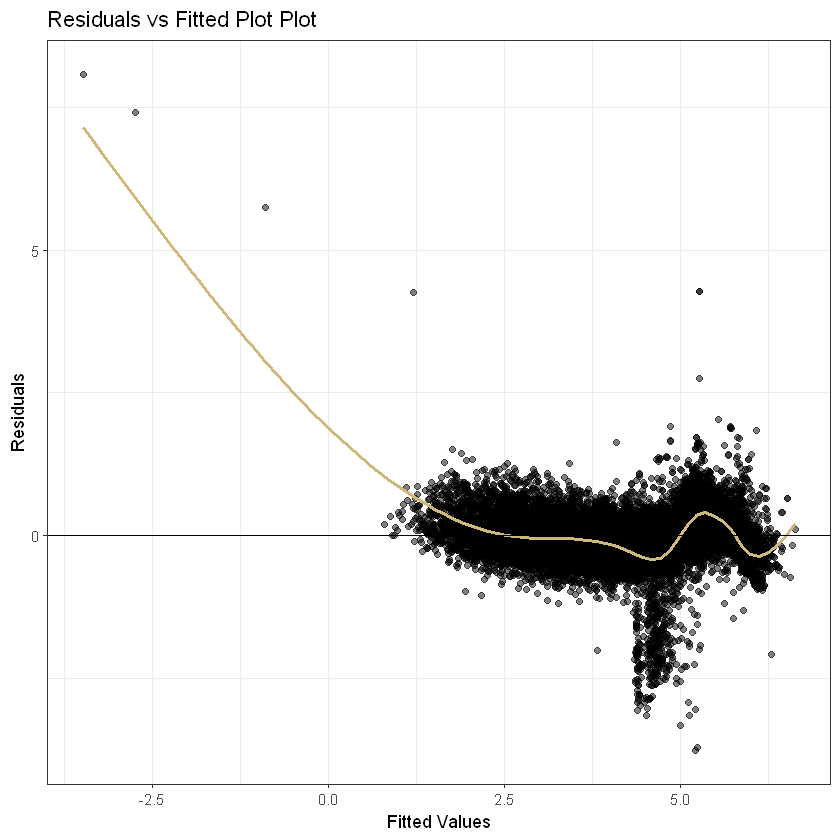

In [296]:

library(ggplot2)
library(car)

df.diagnostics <- data.frame(yhat = fitted(model), r = residuals(model))

# Residuals vs fitted Plot
ggplot(df.diagnostics, aes(x = yhat, y = r)) +
  geom_point(alpha = 0.5) +
  geom_smooth(se = F, col = "#CFB87C") +
  geom_hline(yintercept = 0, color = "black") +
  xlab("Fitted Values") +
  ylab("Residuals") +
    ggtitle("Residuals vs Fitted Plot Plot")+
  theme_bw()

From the above Residuals vs Fitted plot we can see presence of some outliers and also right towards the end of the plot there are many values which have a lower value compared to others. There is a clear visible downward spike, so we can say that constant variance assumption has been violated here.

#### 2) Checking For Normality

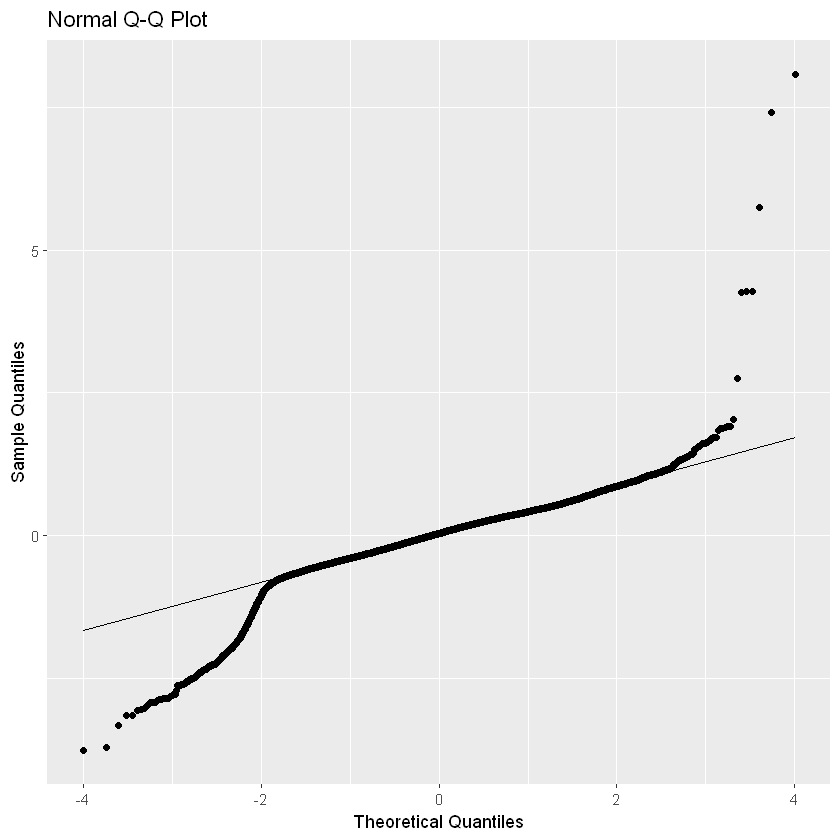

In [297]:
# Normal Q-Q plot
ggplot(train, aes(sample = residuals(model))) +
  stat_qq() +
  stat_qq_line() +
  labs(x = "Theoretical Quantiles", y = "Sample Quantiles") +
  ggtitle("Normal Q-Q Plot")

From the above Q-Q plot we can clearly see that the points are not following a straight line, we can see a lot of point at the top and tail which deviate from the straight line. We can also see the presece of outliers. From this we can say that the assumption of normality has been violated.

#### 3) Checking for Linearity

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


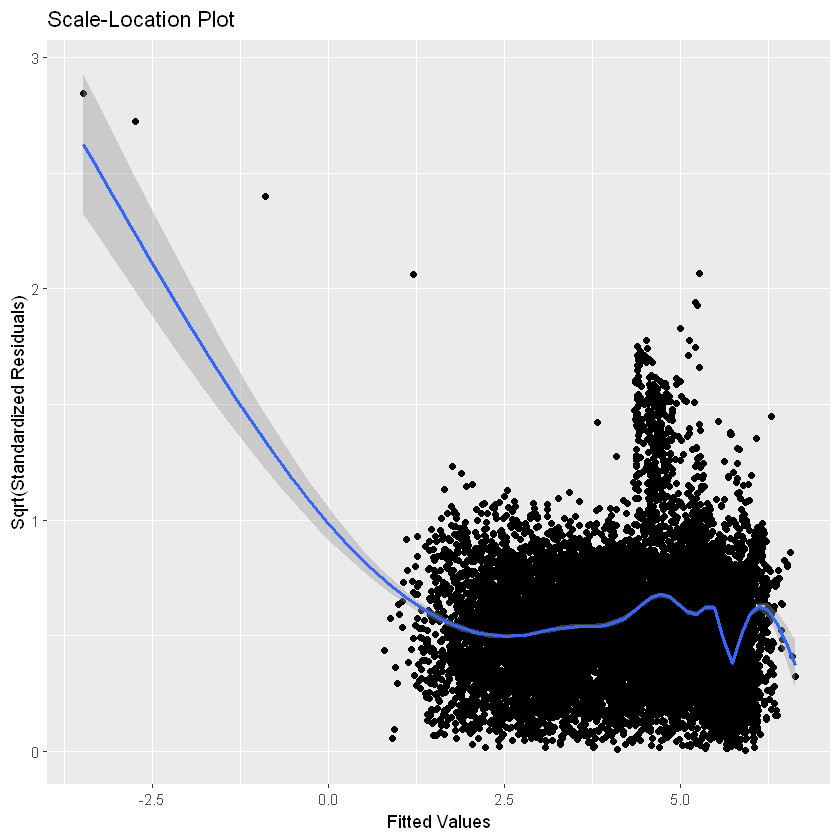

In [298]:
# Scale - location Plot
ggplot(train, aes(x = fitted(model), y = sqrt(abs(residuals(model))))) +
  geom_point() +
  geom_smooth() +
  labs(x = "Fitted Values", y = "Sqrt(Standardized Residuals)") +
  ggtitle("Scale-Location Plot")

From the above scale vs location plot we can clearly see that there is a presence of curvature, which shows that the assumpotion of linearity is violated.

#### 4) Confirming presence of outliers

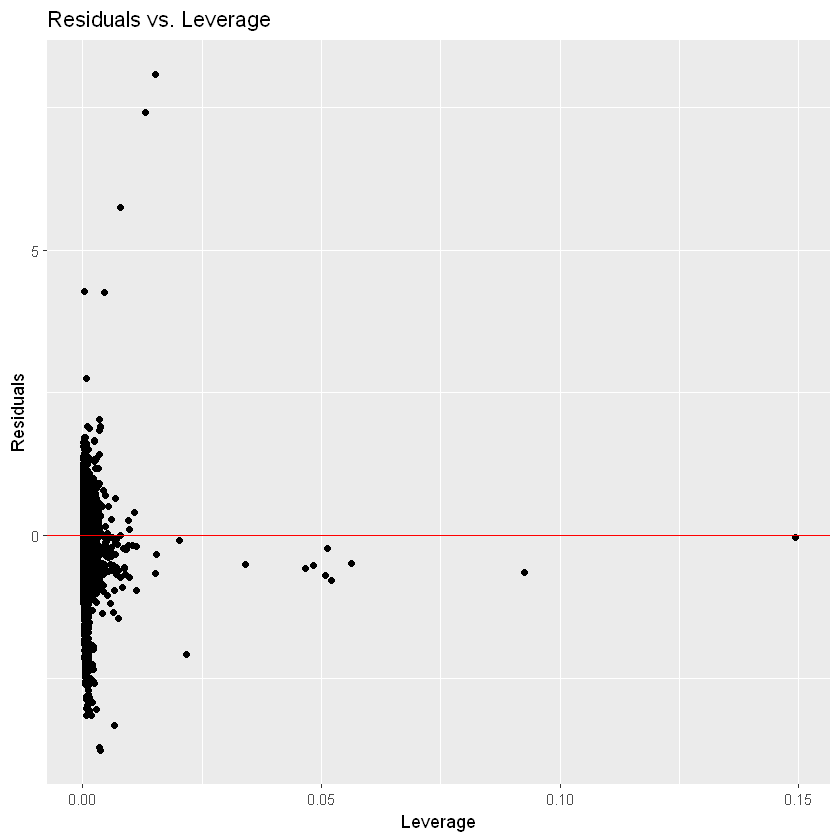

In [299]:
# Residuals vs Leverage
library(car)
ggplot(train, aes(x = influence(model)$hat, y = residuals(model))) +
  geom_point() +
  geom_hline(yintercept = 0, color = "red") +
  labs(x = "Leverage", y = "Residuals") +
  ggtitle("Residuals vs. Leverage")

From the above residuals vs leverage plot we can see the presence of outliers which might be points that can influence the results

#### 5) Multicollinearity

Multicollinearity has already been tested in the strat of this analysis right after cleaning, to recap we have removed to variables that showed high correlation. Then tested VIF values again to get a result which shows that there was no multicollinearity present in the current model.

### Goodness of Fit

Let's review the summary of our model again:

In [300]:
summary(model)


Call:
lm(formula = O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + 
    NO2uM + NH3uM, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7665 -0.2659  0.0344  0.3043  8.0885 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  6.4449114  0.1014648   63.519   <2e-16 ***
Depthm      -0.0023178  0.0001356  -17.098   <2e-16 ***
T_degC       0.0649608  0.0026139   24.852   <2e-16 ***
Salnty      -0.0483205  0.0028386  -17.023   <2e-16 ***
SiO3uM      -0.0865234  0.0006587 -131.361   <2e-16 ***
Phaeop       0.3314825  0.0198599   16.691   <2e-16 ***
NO2uM       -0.0897524  0.0526548   -1.705   0.0883 .  
NH3uM        0.0141123  0.0142852    0.988   0.3232    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5051 on 16230 degrees of freedom
Multiple R-squared:  0.8603,	Adjusted R-squared:  0.8602 
F-statistic: 1.428e+04 on 7 and 16230 DF,  p-value: < 2.2e-16


From the above, the high R-squared and Adjusted R-squared values both around 86% suggest a good fit, indicating that the model explains a substantial portion of the variance in O2ml_L.

Let's verify this with actual vs predicted plot

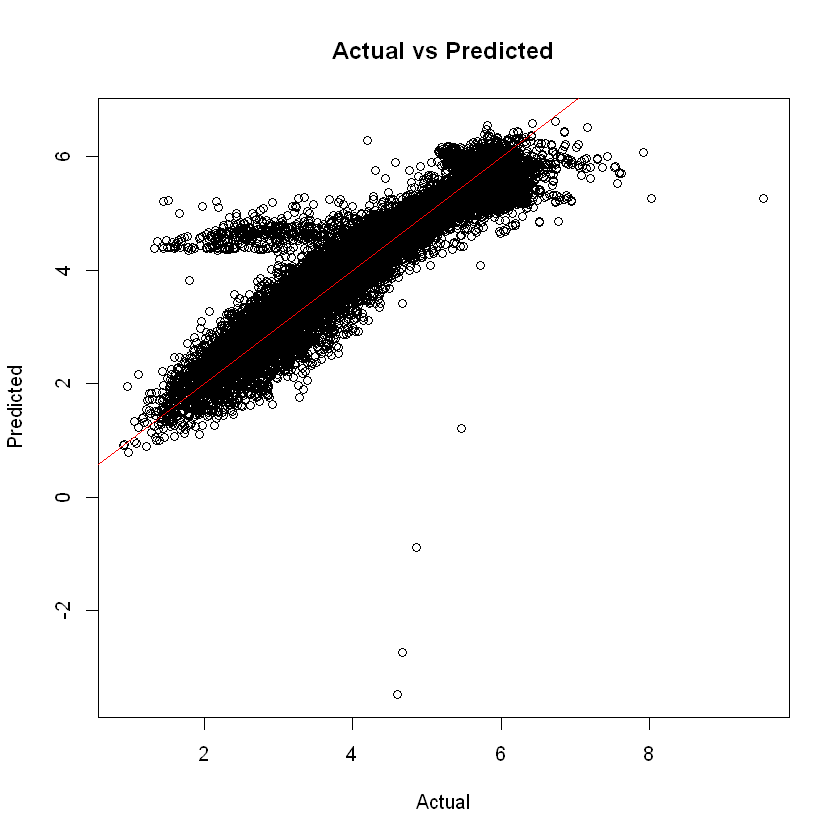

In [301]:
actual <- model$model$O2ml_L  # Replace with your actual response variable
predicted <- predict(model)

# Plotting Predicted vs Actual
plot(actual, predicted, xlab = "Actual", ylab = "Predicted",
     main = "Actual vs Predicted")
abline(0, 1, col = "red")  # Add a 45-degree reference line


From the above actual vs predicted plot we can say that the model is a good fit, but there could be an improvement, due to the presence of outliers and some dispersion present.

### Feature selection

In [302]:
summary(model)


Call:
lm(formula = O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + 
    NO2uM + NH3uM, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7665 -0.2659  0.0344  0.3043  8.0885 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  6.4449114  0.1014648   63.519   <2e-16 ***
Depthm      -0.0023178  0.0001356  -17.098   <2e-16 ***
T_degC       0.0649608  0.0026139   24.852   <2e-16 ***
Salnty      -0.0483205  0.0028386  -17.023   <2e-16 ***
SiO3uM      -0.0865234  0.0006587 -131.361   <2e-16 ***
Phaeop       0.3314825  0.0198599   16.691   <2e-16 ***
NO2uM       -0.0897524  0.0526548   -1.705   0.0883 .  
NH3uM        0.0141123  0.0142852    0.988   0.3232    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5051 on 16230 degrees of freedom
Multiple R-squared:  0.8603,	Adjusted R-squared:  0.8602 
F-statistic: 1.428e+04 on 7 and 16230 DF,  p-value: < 2.2e-16


From these results from the summary of the model we can see that features, 'Depthm' , 'T_degC', 'Salnty', 'SiO3um' and 'Phaeop' are significant predictors. Features 'NO2uM' and 'NH3uM' have p value greater than the significance level.

So, based on p-values we can say that features, 'Depthm' , 'T_degC', 'Salnty', 'SiO3um' and 'Phaeop' are the best to predict the model. 0.3232 

Now let's see which model are best with varying sizes of the predictors and then analyse with various metrics.

#### Model Selection

In [303]:
install.packages('leaps')

,(Intercept),Depthm,T_degC,Salnty,SiO3uM,Phaeop,NO2uM,NH3uM
1,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
3,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
4,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE
6,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
7,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


[1] "The AIC Values are:"


[1] -19491.99 -21212.03 -21597.36 -21890.40 -22173.80 -22173.89 -22172.87

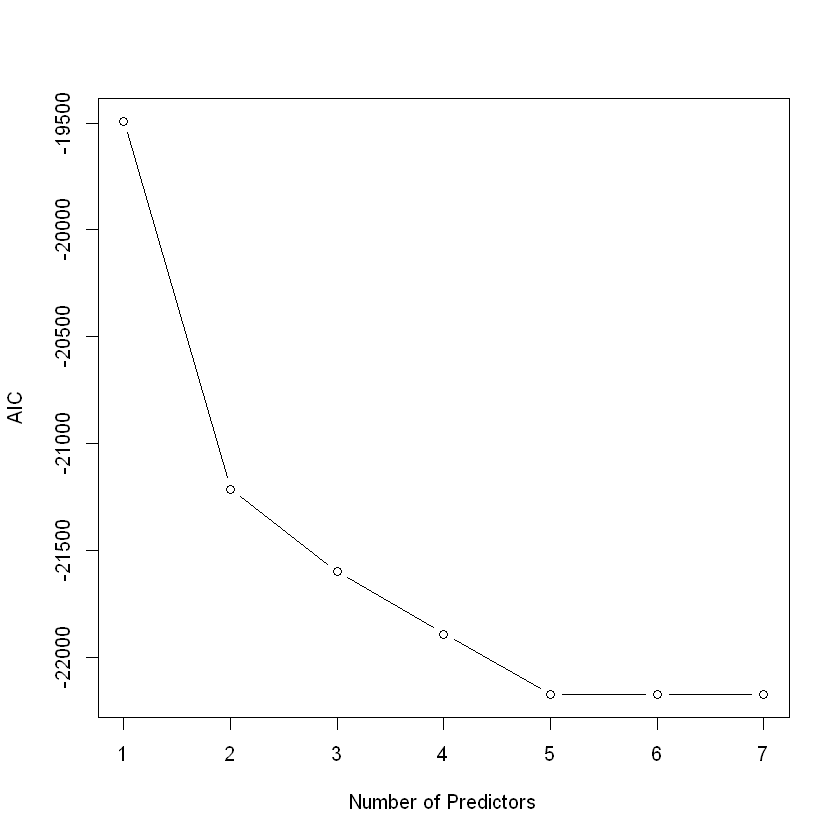

[1] "The BIC Values are:"


[1] -19484.29 -21196.64 -21574.27 -21859.62 -22135.32 -22127.72 -22119.00

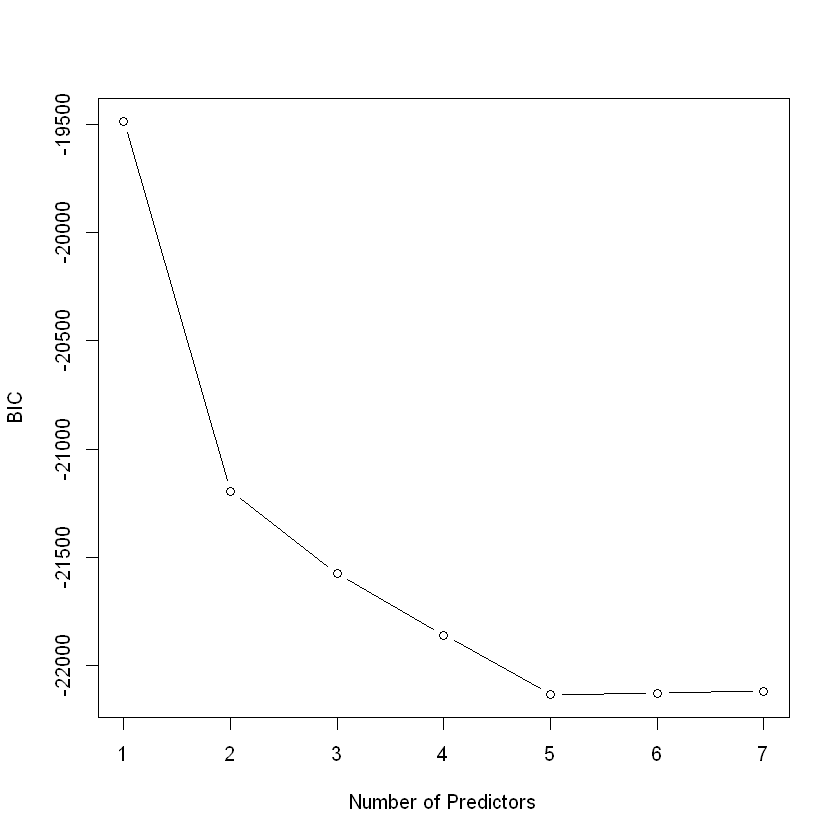

[1] "The adjusted R^2 values are:"


[1] 0.8350784 0.8516638 0.8551513 0.8577506 0.8602204 0.8602298 0.8602296

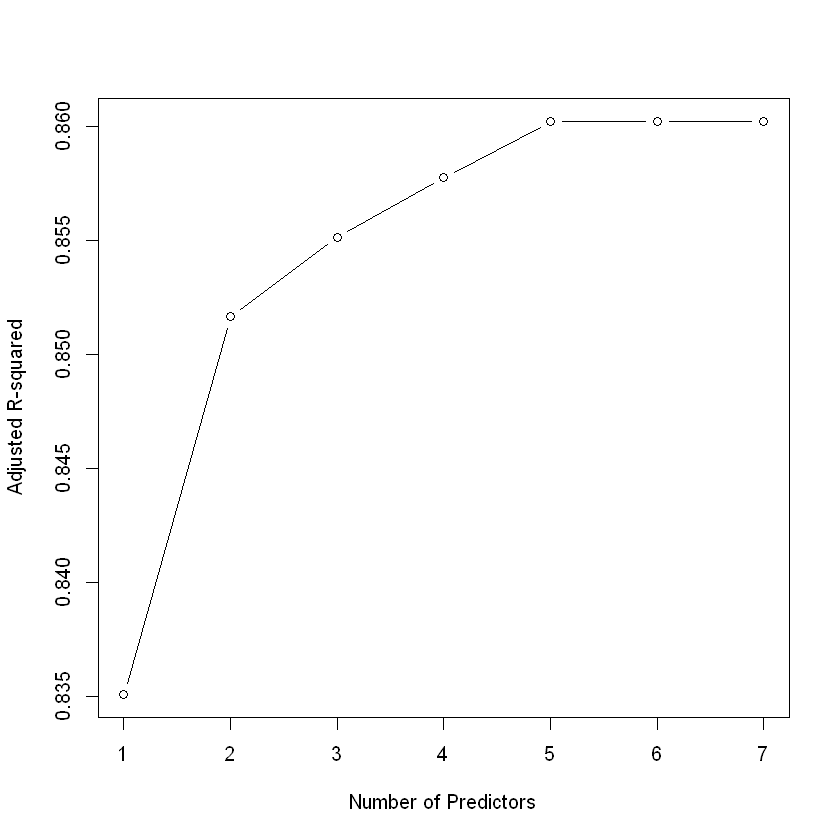

[1] "R^2 values are:"


[1] 0.8350886 0.8516820 0.8551781 0.8577857 0.8602634 0.8602815 0.8602899

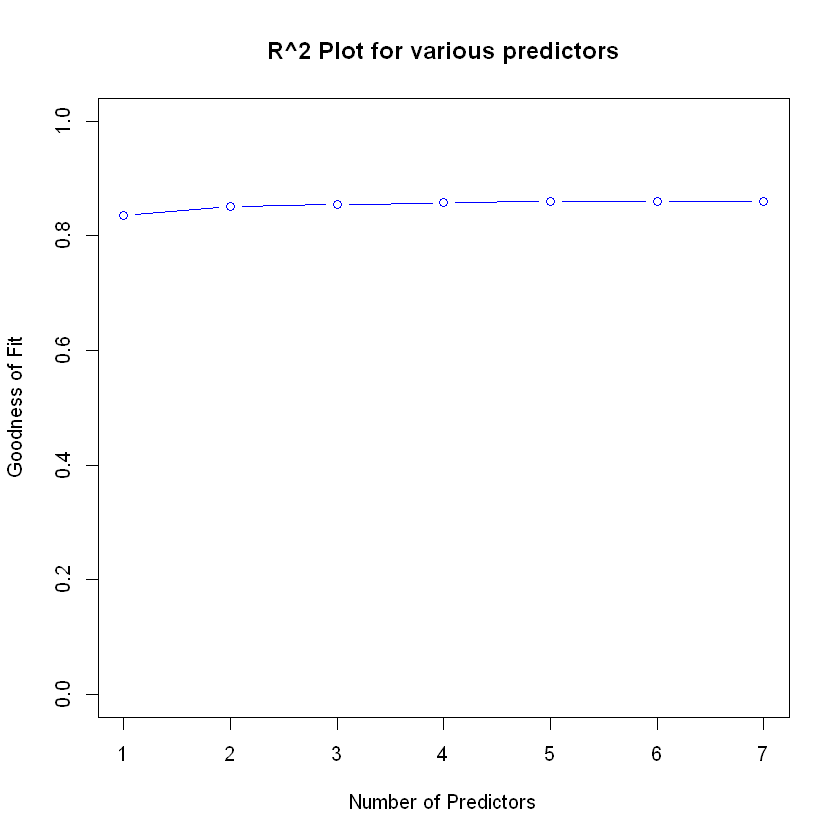

In [304]:
library(leaps)

reg1 <- regsubsets(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + NO2uM + NH3uM, data = train)
rs <- summary(reg1)
rs$which

num_models <- length(rs$rss)

n <- nrow(train)
AIC_values <- 2 * (1:num_models) + n * log(rs$rss / n)  # Calculating AIC values

BIC_values <- log(n) * (1:num_models) + n * log(rs$rss / n)  # Calculating BIC Values

print('The AIC Values are:')

AIC_values


plot(1:num_models, AIC_values, type = "b", xlab = "Number of Predictors", ylab = "AIC") # plotting AIC

plot(1:num_models, BIC_values, type = "b", xlab = "Number of Predictors", ylab = "BIC") # plotting BIC

print('The BIC Values are:')

BIC_values


plot(1:num_models, rs$adjr2, type = "b", xlab = "Number of Predictors", ylab = "Adjusted R-squared") # plotting adjusted R^2

print('The adjusted R^2 values are:')
rs$adjr2

rs$rsq <- 1 - rs$rss / sum((train$O2ml_L - mean(train$O2ml_L))^2)
plot(1:num_models, rs$rsq, type = "b", col = "blue", xlab = "Number of Predictors", ylab = "Goodness of Fit", ylim = c(0, 1)) # plotting R^2
title("R^2 Plot for various predictors")
print('R^2 values are:')
rs$rsq

The best models according to size of the predictors:

1. **Model 1**:
   $
   O2ml\_L = \beta_0 + \beta_{SiO3uM} \cdot SiO3uM
   $
   

2. **Model 2**:
 $
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{SiO3uM} \cdot SiO3uM
$
  

3. **Model 3**:
 $
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{SiO3uM} \cdot SiO3uM
   $
  

4. **Model 4**:
$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop
$
   

5. **Model 5**:
$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop
 $
 

6. **Model 6**:
  $
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop + \beta_{NO2uM} \cdot NO2uM
   $


7. **Model 7**:
  $
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop + \beta_{NO2uM} \cdot NO2uM + \beta_{NH3uM} \cdot NH3uM
 $
  

From the above plots these are the best models selected by each of the metric:


**Best Model by AIC : (The model with lowest AIC value among all is considered best model)**

Model 6:  

$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop + \beta_{NO2uM} \cdot NO2uM
   $

**Best Model by BIC: (The model with lowest BIC value among all is considered best model)**

Model 5:

$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop
 $


**Best Model by Adjusted R^2: (The model with highest adjusted R^2 value among all is considered best model)**

Model 6:

$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop + \beta_{NO2uM} \cdot NO2uM
$

**Best Model by R^2 : (The model with highest  R^2 value among all is considered best model)**

Model 7:

  $
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop + \beta_{NO2uM} \cdot NO2uM + \beta_{NH3uM} \cdot NH3uM
 $
  


From above we can see that various metrics have selected models with various size of predictor sizes. Here  in the above selection when selecting between various metric it is to be noted that model 5, model 6 and model 7 have very close metric values when it comes to all metrics AIC, BIC, R^2 and adjusted R^2. The difference between these models was in decimals places when it comes to comparission of metrics.

Let's confirm the best model by also testing with MSPE values.

In [305]:
reg1 <- regsubsets(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop + NO2uM + NH3uM, data = train)
rs <- summary(reg1)
rs$which


,(Intercept),Depthm,T_degC,Salnty,SiO3uM,Phaeop,NO2uM,NH3uM
1,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
3,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
4,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE
6,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
7,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


The above code is a table showing best features for each size of the predictors

In [306]:
# Fitting models for best predictors in each size

model1 <- lm(O2ml_L ~ Depthm, data = train)
model2 <- lm(O2ml_L ~ Depthm + SiO3uM, data = train)
model3 <- lm(O2ml_L ~ Depthm + T_degC + SiO3uM, data = train)
model4 <- lm(O2ml_L ~ Depthm + T_degC + Phaeop + SiO3uM, data = train)
model5 <- lm(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM+ Phaeop, data = train)
model6 <- lm(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM+ Phaeop + NO2uM, data = train)
model7 <- lm(O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM+ Phaeop + NO2uM +NH3uM, data = train)




In [307]:
# Calculating MSPE Values for each model

calculate_mspe <- function(model, test_data) {
  predictions <- predict(model, newdata = test_data)
  mean((test_data$O2ml_L - predictions)^2)
}

mspe1 <- calculate_mspe(model1, test)
mspe2 <- calculate_mspe(model2, test)
mspe3 <- calculate_mspe(model3, test)
mspe4 <- calculate_mspe(model4, test)
mspe5 <- calculate_mspe(model5, test)
mspe6 <- calculate_mspe(model6, test)
mspe7 <- calculate_mspe(model7, test)


print(paste("MSPE for Model 1:", mspe1))
print(paste("MSPE for Model 2:", mspe2))
print(paste("MSPE for Model 3:", mspe3))
print(paste("MSPE for Model 4:", mspe4))
print(paste("MSPE for Model 5:", mspe5))
print(paste("MSPE for Model 6:", mspe6))
print(paste("MSPE for Model 7:", mspe7))


mspes <- c(mspe1, mspe2, mspe3, mspe4, mspe5, mspe6,mspe7)
best_model_size <- which.min(mspes)
best_mspe <- mspes[best_model_size]

print(paste("Best Model (by MSPE) Size:", best_model_size))
print(paste("Lowest MSPE:", best_mspe))

[1] "MSPE for Model 1: 0.655433188328069"
[1] "MSPE for Model 2: 0.233821960709644"
[1] "MSPE for Model 3: 0.230057677611918"
[1] "MSPE for Model 4: 0.227806616239863"
[1] "MSPE for Model 5: 0.222951882360932"
[1] "MSPE for Model 6: 0.223018899466372"
[1] "MSPE for Model 7: 0.223282001171033"
[1] "Best Model (by MSPE) Size: 5"
[1] "Lowest MSPE: 0.222951882360932"


From the above result we can see that model 5 i.e. :

$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop
 $

has the best fit, since it has the lowest MSPE value.

Even here we can see from the result from Model 4 to Model 7 the MSPE values are very similar with minute difference in decimals.

After the complete analysis from various metrics, I will be choosing Model 5:

$
   O2ml\_L = \beta_0 + \beta_{Depthm} \cdot Depthm + \beta_{T\_degC} \cdot T\_degC + \beta_{Salnty} \cdot Salnty + \beta_{SiO3uM} \cdot SiO3uM + \beta_{Phaeop} \cdot Phaeop
 $

as the best model.


Reason:

- Less predictor make it simple to make predictions
- BIC has choosen model 5 and having the lowest BIC, says us that Model 5 is preferable for balancing model fit and complexity.
- MSPE has choosen model 5, it suggests that additional predictors dont have an impact in improvement of the model.


In [308]:
install.packages('car')

Since we have selected model 5 as the best model, let's verify if it has any collinearity

In [309]:
library(car)


calculate_vifs <- function(model) {
  vif(model)
}

# Calculation VIF values
models <- list(model5)

vifs <- calculate_vifs(model5)
cond_number <- kappa(model5)

print("VIFs:")
print(vifs)


[1] "VIFs:"
  Depthm   T_degC   Salnty   SiO3uM   Phaeop 
3.961719 3.970993 1.032122 3.285528 1.268528 


From the above results we can say that there is no collinearity present in this 5 predictor model, since all VIF values are below 5.

Finally let's have a final look at the summary at our best selected model i.e. model 5

In [310]:
summary(model5)


Call:
lm(formula = O2ml_L ~ Depthm + T_degC + Salnty + SiO3uM + Phaeop, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7491 -0.2664  0.0342  0.3044  8.0849 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.4205975  0.1003686   63.97   <2e-16 ***
Depthm      -0.0022869  0.0001336  -17.12   <2e-16 ***
T_degC       0.0658894  0.0025517   25.82   <2e-16 ***
Salnty      -0.0481107  0.0028359  -16.96   <2e-16 ***
SiO3uM      -0.0864192  0.0006560 -131.75   <2e-16 ***
Phaeop       0.3235582  0.0187262   17.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5052 on 16232 degrees of freedom
Multiple R-squared:  0.8603,	Adjusted R-squared:  0.8602 
F-statistic: 1.999e+04 on 5 and 16232 DF,  p-value: < 2.2e-16


From the results from our best model, we can see that, we have a solid adjusted R^2 value of 86% which  suggest that 86% of variance dissolved in oxygen levels is explained by the model. From the P values also we can see that all of the predictors have significant impact since the p-values for all are very low.

Let's have a final look at diagnostics with this best model with 5 predictors

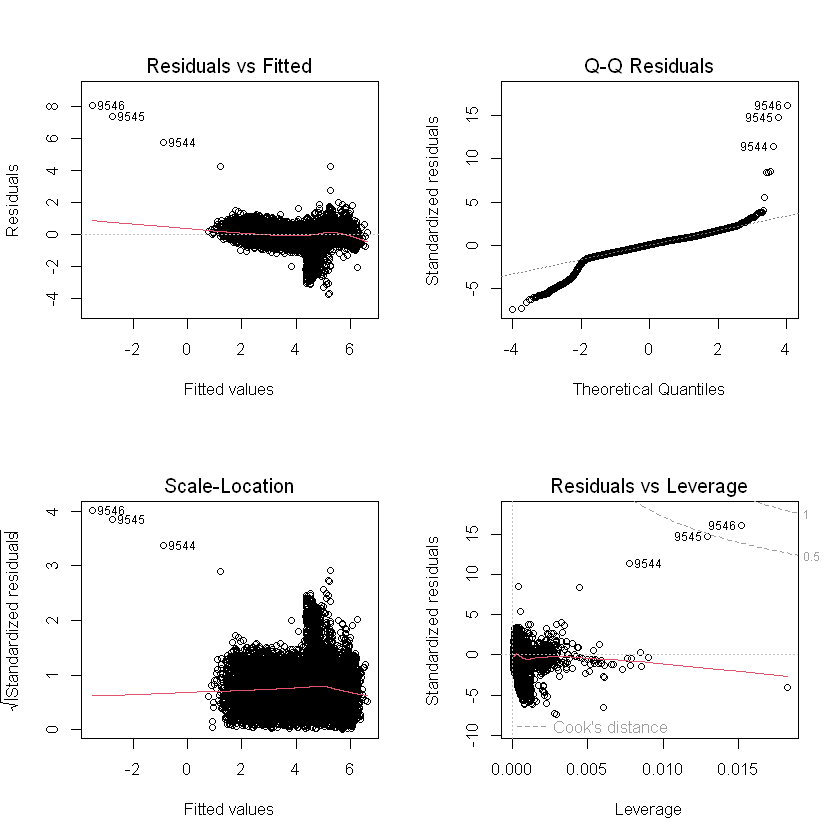

In [311]:
par(mfrow = c(2, 2))  # Arrange plots in a 2x2 grid
plot(model5)

Again, we can see very similar graphs and we can also see similar violations when it comes to normality, constant variance and presence of outliers. So, here the results are similar to 7 predictor model.

Overall, we can conclude that the model with 5 predictors - Depth, temperature of water, Salanity of water,Silicate concentration and Phaeophytin concentration are the best predictors to predict the oxygen concentration. A model which can explain 86% of variance dissolved in oxygen levels is achieved. Better results can be obtained if more examination was done on outlier values and trying out non-linear fitting.
     

## Report ##


### Topic: **Understanding Oxygen Dynamics in Oceanographic data : The Influence of Environmental Variables** ###

##### 1. Introduction ##### 
Oceanic oxygen concentrations are fundamental for marine ecosystems, supporting biodiversity and influencing key biogeochemical processes. Oxygen levels in sea water can fluctuate due to various environmental factors. This study investigates how depth, temperature, salinity, and various nutrients influence oxygen concentration in seawater within California Sea Coast. A similar study related to this data was done on Sea Surface Temperature  by Sivasankari, Manickavasagam & R, Anandan.{(2020). Regression Analysis on Sea Surface Temperature. 10.1007/978-981-15-3284-9_68}. In their paper they analysed sea surface temperature over salinity using different methods like linear regression, decision tree, random forest, and SVR. They have performed these various regression analysis and compared the models. They found that temperature and salinity do not have that strog of a relation. 

The dataset used in this analysis is a subset of bottle dataset maintained by California Cooperative Oceanic Fisheries Investigations (CalCOFI).  This analysis focuses on the years 2017-2021. This observational study includes parameters such as temperature, salinity, dissolved oxygen, and nutrients. CalCOFI first collects Seawater from various sampling depths using 10-liter Niskin bottles attached to a 24-place CTD-Rosette frame. Then they measure environmental parameters using chemical analyses (i.e. titrations and assays) from the seawater samples. Finally CalCOFI  compiles the data into the Bottle Database. CalCOFI collectes this data to to understand and predict the effects of climate change on marine ecosystems. 

The primary questions of interest in this research are:

1) Which environmental variables are the most important predictors of oxygen concentration?
2) How well can a linear model explain the observed variability in oxygen levels?
3) Is depth is a significant predictor for response variable - oxygen concentration?
4) Is there a significant relationship between any of the predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop, NO2uM, and NH3uM) and the dissolved oxygen levels (O2ml_L) 

##### 2. Methods/Results ##### 

The CalCOFI dataset taken from CalCOFI research program website. Two datasets were taken from this site, one is bottle dataset and other a cast dataset which contains corresponding  date and year of recorded data in bottle dataset. These two dataset were used to filtere and to include the years 2017-2021 and relevant physical and nutrient variables. The main variables used in this analysis are:

**Dependent Variable**:

O2ml_L - Oxygen in mL/L	- Milliliters of dissolved oxygen per Liter seawater

**Independent Variables**:

Depthm (Depth in meters)
T_degC (Temperature of water) (Degrees C)
Salnty (Salinity of water) (Practical Salinity Scale)

PO4µM - Phosphate concentration (micro Moles per Liter)
SiO3µM -Silicate concentration - (micro Moles per Liter)
NO3µM - Nitrate concentration - (micro Moles per Liter)
Phaeop -Phaeophytin concentration measured fluorometrically (µg/L)
NO2uM - Nitrite concentration (micro Moles per Liter)
NH3uM - Ammonium concentration - (micro Moles per Liter)

Data Cleaning was performed first, where it was found out that various columns had missing values. Columns like temperature and salinity which had missing values less 10 were removed. To handle remaining missing values, first skewness was checked using density plots. These density plots can be see below.

<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihaLjEthq50fg51ZjgsctBheUoOxNkmEhzdpioVE_qd-xHWrMINMC252ImBQ4PQY0e93VOSMbVuSnxF3opyaHsq_iMYYhXdm3UY=s1600-rw-v1" alt="Drawing" style="width: 350px;"/> 

<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY6ftN25xb0v3XPvE2-CN7DngG4cijxa_xKoP96tv3MU3a5xphXr3ZrTD4f3b4EQxL-r9Q6t2Xa10JOhaEp0QReLqYPzhQhi5U=s1600-rw-v1" alt="Drawing" style="width: 400px;"/> 

<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihaFTcNCOVuCypFsB839WP3hOGU5JZ9KcNu9Z1gVM70x03-79h6uwAzUqy6jIVN7jtzjDJKF0pJjUD-T7-TsGQlkqCuH0xM9VA=s2560" alt="Drawing" style="width: 400px;"/> 


After verifying the density plots, due to the presence of skewness in all the variables having missing values, median was choosen as the imputaition method to replace the missing values. Some unrealistic values were removed in all the columns . Summary statistics was compared before and after cleaning to ensure there were no major changes.

To answer the questions to find the best predictors it was decided that regression modelling, particularly multiple regression was found suitable. First the dataset was randomly split into traning and test set with 80% of the data into traning set and 20% of data for testing. Initailly a correlation plot was plotted to examine which independent variables have high correlation among each other. 


<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYFwvfawi-et4U1ys0kCLpAuzSlxfoOQDq_w4K1iiSRPaYPLVAI3RrBrRX2jem4Pu6g0kee7iSfZRF2Qu3thnR5IDkK5eWamA=s2560" alt="Drawing" style="width: 400px;"/> 

It was observed that 'PO4uM', 'NO3uM' and 'SiO3uM' had a very high correlation among other variables from the above scatter plot. To verify this first a multiple linear regression model was fitted and variance inflation factors (VIFs) was observed for various features. It was confirmed that 'PO4uM', 'NO3uM' and 'SiO3uM' had high correlation due to their high values. To reduce multicollinearity 'PO4uM', 'NO3uM' features were decided to be removed from the analysis since they have VIF values more than 100.
The multiple linear regresssion was done again and multicollinearity was checked for remaining seven predictors. It was found that there was no presence of multicollinearity in these seven predictor variables.

Regression analysis was now performed on the remaining seven predictor variables. Summary of regression model was analysed and it was found that 86% of variance dissolved in oxygen levels is explained by the model, this is evident from the Adjusted $R^2$ value of 86% from the model. It was also observed that that all the predictors except nitrite concentration ('NO2uM') and Ammonium concentration ('NH3uM') are statistically very good predictors with the response variable - O2ml_L i.e. oxygen concentration.

A t-test was performed to check if depth was a strong predictor for the response variable oxygen concentration. Due the very low p-value observed null hypothesis was rejected and it was concluded that there is a statistically significant relationship between Depthm and O2ml_L features.

To find if there is a significant relationship between any of the predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop, NO2uM, and NH3uM) and the dissolved oxygen levels (O2ml_L), hypothesis test with ANOVA was used. From the results of the test it was observed that Depthm, T_degC, Salnty, SiO3uM, and Phaeop had very low p-values and NO2uM and NH3uM had p-values above significance level of 0.01. Since more than one variable which has significant relation with the response variable was present, there was significant evidence to reject the null hypothesis at the α = 0.01 level. So, it was seen that that at least one of the predictors (Depthm, T_degC, Salnty, SiO3uM, or Phaeop) is significantly associated with the response variable, O2ml_L. NO2uM and NH3uM do not significantly explain the variance in O2ml_L, as their p-values are greater than 0.01.

To check for validity of Regression and ANOVA assumptions Diagnostic Analysis was performed. Various diagnostic plots were plotted to check for violations.

1) Residuals Vs Fitted Plot

   
   
   
<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpiha5CP-tDr5sZF9xbV9BtHUptX5-ROxkqvLNn2w-92iJmV-VPzRZU52K-esBnuI89sumUxK__mchN3n4nyhTqm2WmQEUAyTFoQ=s2560" alt="Drawing" style="width: 400px;"/> 






From the above Residuals vs Fitted plot the presence of some outliers and also right towards the end of the plot there are many values which have a lower value compared to others. There is a clear visible downward spike, so the constant variance assumption has been violated here. 

2) Normal Q-Q Plot

   
   
<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihb4PBotUxtbUQyGQaE5zvAoajwyDzspXUUzAao55IWk13cgeNXRQEZtse_BF-SIeGHO9xgOuMSOmORpzIPsdHQKO4_2I7_8-Ws=s2560" alt="Drawing" style="width: 400px;"/> 



From the above Q-Q plot it is clearly seen that the points are not following a straight line, it can be seen that a lot of points at the top and tail deviate from the straight line. The presece of outliers is also evident. So, the assumption of normality has been violated.

3) Scale and Location Plot
   


   

<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY9Et__vtfdMl8PtTRhhl_5UWmZg520uNri5LGHPg11gLKVioLCVQA8p84PklFvystqMJjaLpajoogon1d_vsYHH_cShllXGqI=s2560" alt="Drawing" style="width: 400px;"/> 





From the above scale vs location plot it can be clearly seen that there is a presence of curvature, which shows that the assumption of linearity is violated.

4) Residual and Leverage Plot

   
   
<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY9ZXoK5eK7rzx_WjOgXIuj5QbbiPj01fCIcvUrgUAn-0x5dUlRPUXmqwSmCATnNxzM-wYj7qybJZF-HlgnURcmAsJFfYdgziU=s2560" alt="Drawing" style="width: 400px;"/>



From the above residuals vs leverage plot it the presence of outliers which might be points that can influence the results is evident.

The goodness of fit for the model was analysed with the summary statistics of the model. From the summary of the multiple linear regression model a high R-squared and Adjusted R-squared values both around 86% was found. This suggest a good fit, indicating that the model explains a substantial portion of the variance in O2ml_L. This result was further verified by plotting actual vs predicted graph.

<img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY0bGv1amAhLxrE2XFc-CuZZdEu89Jj-HUR2II3ntStLGFcfdsQGrqG4oVyjyic64BUeqrgv4fu9R_DFYKkn2nViDRc47c3pLE=s2560" alt="Drawing" style="width: 400px;"/>

From the above actual vs predicted graph it can be said that the model is a good fit, but there could be an improvement, due to the presence of outliers and some dispersion present.

To identify the most best predictive model, a combination of metrics (AIC, BIC, MSPE, R-squared, and adjusted R-squared) was considered. All of these metrics had almost similar results with models with 5,6 and 7 features.  A model with five predictors (Depthm, T_degC, Salnty, SiO3uM, Phaeop) was choosen as the best model for this analysis. This was due to the fact that less predictor make it simple to make predictions and
BIC has choosen model 5 and having the lowest BIC, says us that Model 5 is preferable for balancing model fit and complexity. MSPE has choosen model 5, it suggests that additional predictors dont have an impact in improvement of the model. 

A summary of this five preictor model was revealed that all the features are very good predictors due to the presence of low p-values. The adjusted $R^2$ value of 86% remained same from initail model Finally diagnostics and collinearity tests were done to this five predictor model. It was observed that the diagnostics remained with simialar residual grpahs with violations in constant variance, normality and presence of outliers and violation of linearity. It was found that this five predictor model has no collinearity since all features had VIF values less than 5. 

**Conclusion**

This analysis highlights the strong influence of environmental variables on oxygen concentration in sea water in the California Sea Coast. It was found that depth, temperature, salinity, silicate concentration, and phaeophytin concentration all emerged as significant predictors. The selected model provides a solid foundation for understanding oxygen variability as 86% of variance dissolved in oxygen levels is explained by the model. The diagnostics revealed various violations of assumptions. t-test and ANOVA further supported the importance of the selected predictors. A t-test confirmed a strong influence of depth on oxygen concentration. ANOVA indicated at least one predictor was significantly associated with oxygen. A further research could include finding the reasons behind the violations of assumptions of regression by the model. Various transformations can be tested with model to reduce the violations. Additional features like chlorophyll-a can be included and be teseted as predictors with the model.